In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.corpora import Dictionary
import time
import spacy
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/reviews-a/reviews_playstore_all.csv
/kaggle/input/original-urbanclap/urban.clap.data.csv


In [95]:
data = pd.read_csv('/kaggle/input/original-urbanclap/urban.clap.data.csv')
# data = pd.read_csv('/kaggle/input/original-urbanclap/urban.clap.data.csv')
print(data.shape)
#data = data.dropna()
rows_missing_content = data[data['review'].isnull()]
data = data.dropna(subset=['review'])
stemmer = PorterStemmer()
print(data.shape)
lemmatizer = WordNetLemmatizer()

(1554516, 10)
(375869, 10)


In [96]:
data.head()

,responded_pro_booking,customer_request_id,total_jobs,approval_date,gender,city,rating,review,review_tags,date_of_service
4,5af9873483ed9e2200f233d1,5b0feb16ce31b9210004e4f5,992.0,2018-05-28,female,city_hyderabad_v2,5.0,She created very friendly atmosphere and did her service really well. Appreciate her efforts.,NaN,2018-06-01 08:00:00
16,5a72a9cb90a4e35f00b548e1,5b100b4287bce02100f9f6f4,522.0,2018-02-05,female,city_kolkata_v2,5.0,Nice service..happy.,NaN,2018-06-01 09:00:00
19,5a9983bec435cc60005748e9,5b0ff1aa4c58232200e24361,689.0,2018-04-03,female,city_chennai_v2,5.0,"As expected , Wonderful service from her.",NaN,2018-06-01 09:00:00
20,592bd83757ad9efb2b6ee5f7,5b0f85c5e5d5992200d07ad9,501.0,2017-06-06,female,city_pune_v2,5.0,Muskaan is very efficient at her work,Professional's Skill;Punctuality;Professional's Behaviour,2018-06-01 09:00:00
25,5a4638ac8521105d00ac802c,5b0d64da2ef62f2100bba2a8,726.0,2018-01-05,female,city_delhi_v2,5.0,it is my first time on urbanclap and i love the experience. everything was professional yet homely. definitely going for some more in future. Anju is so friendly and very professional too.,Professional's Skill;Professional's Behaviour,2018-06-01 09:00:00


In [97]:
def frequent_words(x,n = 30):
    words = ' '.join([str(text) for text in x if isinstance(text, str)])
    c_words = words.split()

    frequency_distribution = FreqDist(c_words)
    words_df = pd.DataFrame({'word':list(frequency_distribution.keys()), 'count':list(frequency_distribution.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = n) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

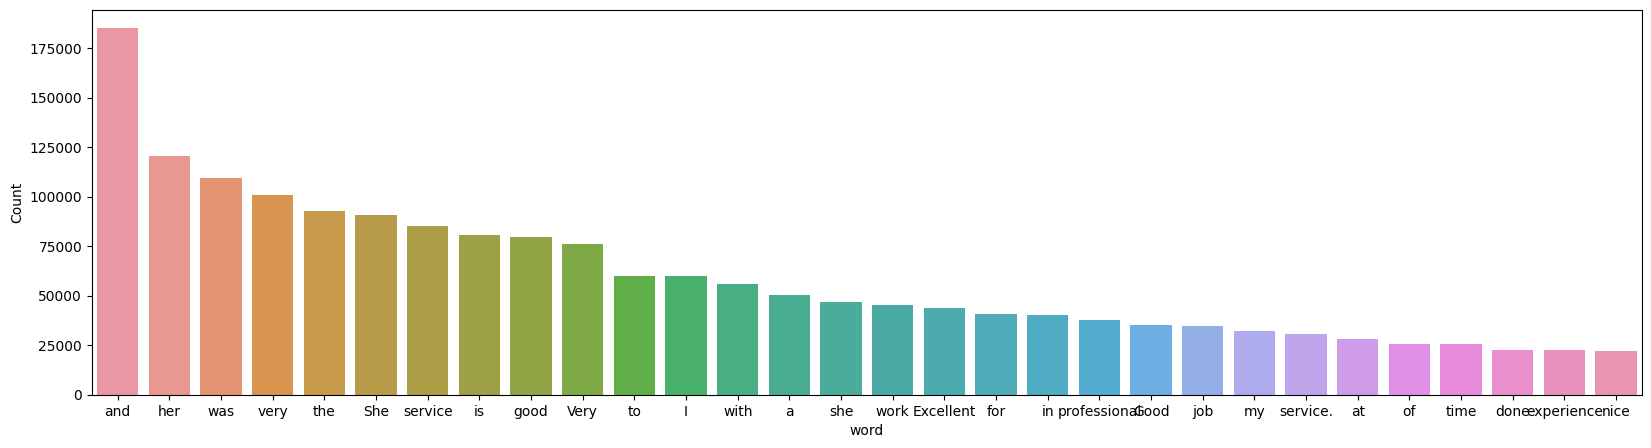

In [98]:
frequent_words(data['review'])

In [99]:
#preprocessing
# for removing punctuations, symbols and other special characters
stop_list =  stop_list = stop_words + ["do", "good", "bad", "nice""awesome", "superb", "excellent", "go", "grt8", "very", "there",
                              "one", "two", "three", "first", "second", "third", "1st", "2nd", "3rd", 
                              "four", "five", "six", "seven", "eight", "nine", "zero", "ten", "twenty", 
                              "hundred", "thousand", "million", "billion", "trillion","nice","service.","service","do","keep"] 
def remove_stopwords(rev):
    rev_words = rev.lower().split()
    rev_new = " ".join([word for word in rev_words if word not in stop_list])
    return rev_new
data['review'] = data['review'].apply(lambda x: str(x))
data['review'] = data['review'].str.replace("[^a-zA-Z#]", " ")

# for removing words less than 2
data['review'] = data['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
reviews = []  
for content in data['review']:     #'content'
    content = str(content)
    processed_review = remove_stopwords(content) 
    reviews.append(processed_review)

# make entire text lowercase
reviews = [r.lower() for r in reviews]

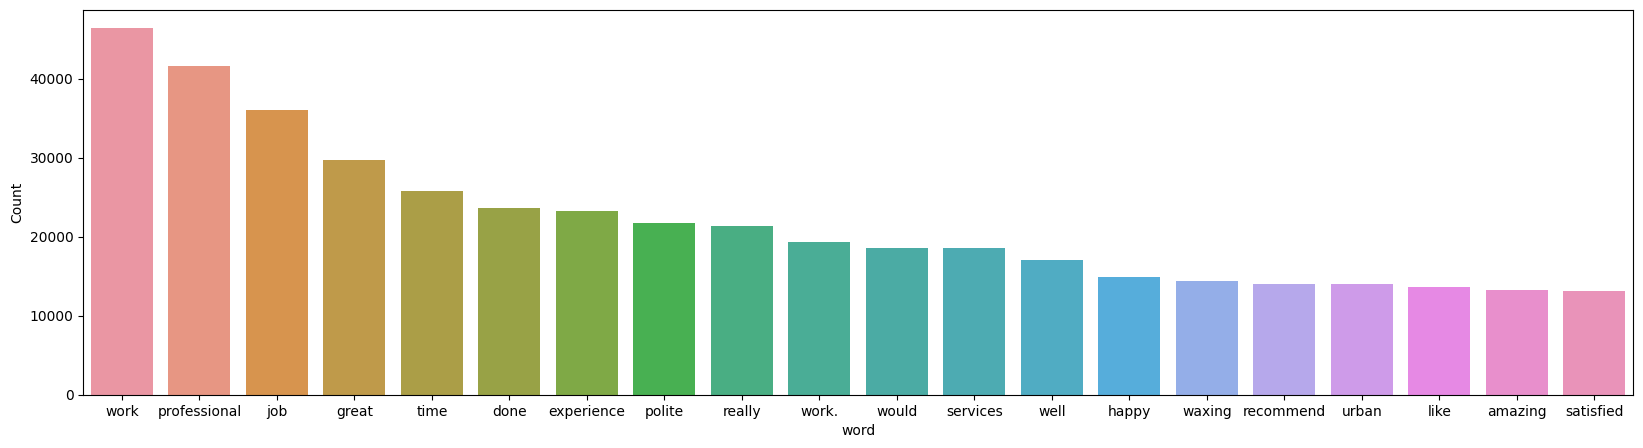

In [100]:
frequent_words(reviews,20)

In [101]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN','VERB']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [102]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
for word in tokenized_reviews:
    if(word in stop_list):
        tokenized_reviews.remove()  
print(tokenized_reviews[1000])

['thorough', 'professional', 'clean', 'work.', 'brought', 'materials', 'provided']


In [103]:
import gensim
bigram = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_reviews], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [104]:
start_time = time.time()
reviews_l = lemmatization(tokenized_reviews)
end_time = time.time()
lematization_time = end_time - start_time
print(f"Lemmatization took {lematization_time:.4f} seconds.")


Lemmatization took 1047.4140 seconds.


In [108]:
reviews_l = [item for item in reviews_l if item is not None and item != '' and item != []]

In [109]:
import pandas as pd

# Assuming reviews_l is a list of lemmatized reviews
# Example: reviews_l = ["lemmatized review 1", "lemmatized review 2", ...]

# Create a DataFrame with 'content' column
preprocess = []
for i in reviews_l:
    word_string = ' '.join(i) 
    preprocess.append(word_string)
df = pd.DataFrame(preprocess, columns=['content'])

# Specify the file path for the CSV file
csv_file_path = 'lemmatized_reviews.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)


In [110]:
csv_file_path = 'lemmatized_reviews.csv'

# Read the CSV file into a new DataFrame
loaded_df = pd.read_csv(csv_file_path)

# Print the head of the loaded DataFrame
print("Head of the Loaded DataFrame:")
print(loaded_df.head())
loaded_df.to_csv("preprocessed.csv")

Head of the Loaded DataFrame:
                               content
0  create atmosphere appreciate effort
1                               expect
2                         muskaan work
3  time love experience go future anju
4                               repeat


In [111]:
s_time = time.time()
dict = Dictionary(reviews_l)
document_term_matrix = [dict.doc2bow(review) for review in reviews_l]
lda_model = LdaModel(corpus=document_term_matrix, id2word=dict, num_topics=8, random_state=100, chunksize=1000, passes=50)
e_time = time.time()
lda_time = e_time - s_time
print(f"LDA time took {lda_time:.4f} seconds.")

LDA time took 2320.4530 seconds.


In [112]:
topics = [
    [(word, float(prob)) for word, prob in re.findall(r'"([^"]*)"\s*\+\s*([0-9.]+)', topic_str)]
    for topic_id, topic_str in lda_model.print_topics()
]

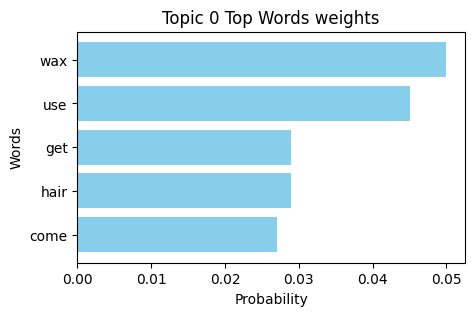

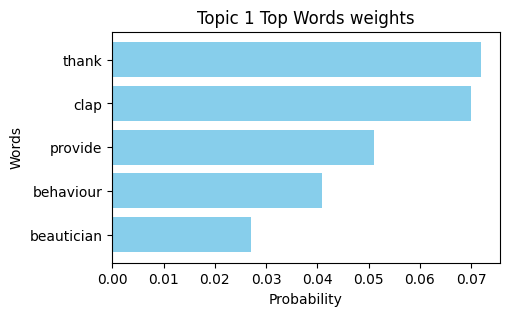

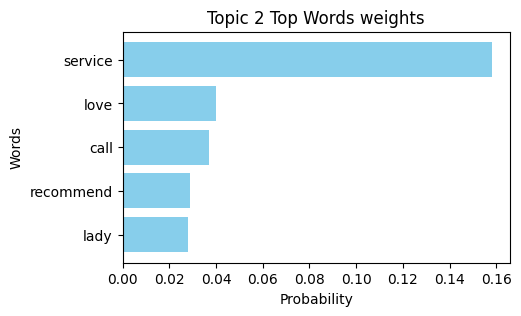

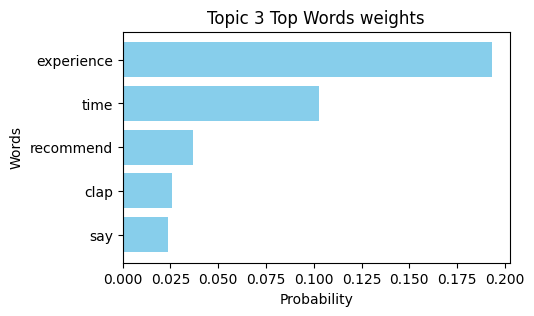

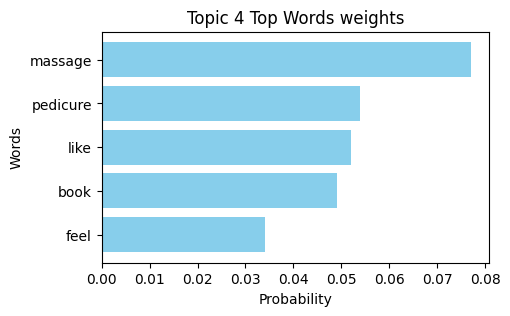

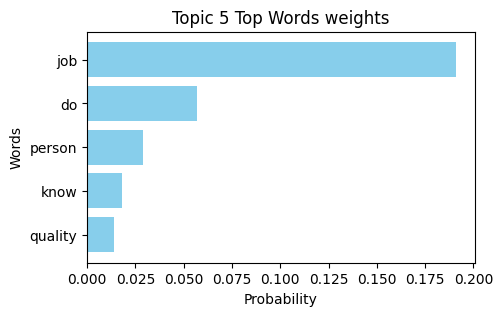

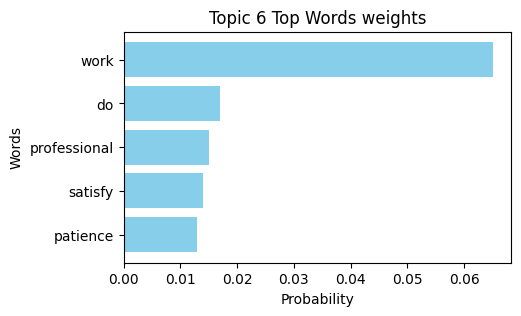

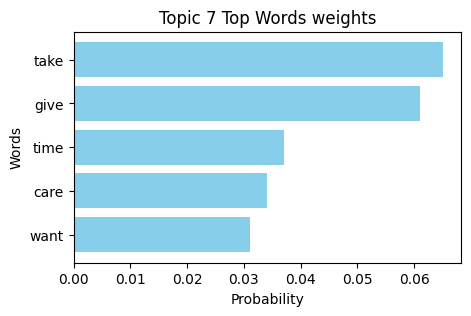

In [113]:
lda_model.print_topics()
for topic_id, topic_words in enumerate(topics):
    # Sort the words and probabilities in descending order based on probabilities
    sorted_words_probs = sorted(topic_words, key=lambda x: x[1], reverse=True)
    
    # Select the top 5 words and probabilities
    top_words, top_probabilities = zip(*sorted_words_probs[:5])
    
    # Create a bar plot
    plt.figure(figsize=(5, 3))
    plt.barh(top_words, top_probabilities, color='skyblue')
    plt.xlabel('Probability')
    plt.ylabel('Words')
    plt.title(f'Topic {topic_id} Top Words weights')
    plt.gca().invert_yaxis()
    plt.show()

In [114]:
latent_space_representation_old = lda_model.get_topics()

In [115]:
data1 = pd.read_csv('/kaggle/input/reviews-a/reviews_playstore_all.csv')
# data = pd.read_csv('/kaggle/input/original-urbanclap/urban.clap.data.csv')
print(data1.shape)
rows_missing_content1 = data1[data1['content'].isnull()]
# print(rows_missing_content)
# print(data['content'][238])
# rows_missing_content = data[data['review'].isnull()]
# data = data.dropna(subset=['review'])
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

(107062, 11)


In [116]:
data1.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,f2a7f983-75d9-4c3b-b306-4c4772b5ad5b,Aparna singh,https://play-lh.googleusercontent.com/a/AAcHTtc9Yqp0trV07irh_jXXpFKECppI8Qm7L1P3Wif3239c=mo,"There is no clarity for the services and there tarrifs. You opt for a service you get a quote from the service guy that you accept to pay. When you get the tax invoice, it is different from the one you accepted in first place. Then if you ask for a revised correct invoice, you are left with vague responses and explanations. We can't even get the correct invoice of the service taken from UC. Not done. Disappointed!!",1,103,7.5.9,04-08-2023 10:20,"Hi Aparna,\nApologies for the less-than-ideal experience. Please share detailed feedback of what went wrong, we assure you that we would help you with your concern. Please share the registered contact details along with your concern to resolve@urbancompany.com.\nRegards, Team Urban Company",04-08-2023 10:26,7.5.9
1,d7f92130-0430-4eb0-8582-aac4c6770abc,Shiv G,https://play-lh.googleusercontent.com/a-/AD_cMMRfPUoVd3NI0DdmVq7opJaBMFatttcmIpoGuF1rB4IpbvQ,"I just can't find your phone no. Or call me back option. There used to be an option to talk to customer care where someone used to guide on requirements. Due to lack of that I am not able to book your services. I looked everywhere in the app but just can't find how to connect to customer care, It's so annoying.. not sure if it's app design issue or intentionally they did it. If intentional I can only wonder why !! If customer can't talk to you how they will be able to book services !!!",1,673,7.4.99,01-06-2023 13:08,"Hi Shivesh,\nWe're really sorry that you’re experiencing problems. You can always reach out to us through the help center section on our app. However, please help us with your registered contact details and concerns at resolve@urbancompany.com and we will have a call arranged for you.\nRegards, Team Urban Company",01-06-2023 13:24,7.4.99
2,f25b2b7b-eaf3-4a3f-9c2d-8aed464aca1d,Shatabhisha Ghosh,https://play-lh.googleusercontent.com/a-/AD_cMMTDlTsmh91_lujh1MtFtxpyRvxoLb5lR7RRWHAKjjtYmls,App does not open when you need it to open and if it does it is so slow...horrible I have been trying to cancel my booking but it does not happen and the app starts working just when the partner is about to come and then you cannot cancel and is forced to take the service. Pathetic The more number of service you take higher are the taxes without explanation,1,4,7.5.11,29-08-2023 03:25,"Hi Shatabhisha,\nWe apologize for the inconvenience caused. Kindly share your contact details with us at resolve@urbancompany.com. We will prioritize your concern and reach out to you via call to address the issue promptly.\nRegards, Team Urban Company",29-08-2023 03:38,7.5.11
3,78dab723-dc59-4f21-8ffb-723d6b1fedb3,Madhurjya Baruah,https://play-lh.googleusercontent.com/a-/AD_cMMQLdgZpXTrE0d_aHFPPIX2nUzXgIVgr65Qm3B7e7vXwsAI,"The application is becoming more and more unusable now a days. Their service persons doesn't show up, the app do not give the option for pay online after service option while booking any service. So they want the money upfront, but without any guarantee that you will get the service on time as promised! Moreover, their non-existent customer support in making the thing worse overall. We need an alternative now. Urban company has lost is completely.",2,13,7.5.10,15-08-2023 14:49,"Hi Madhurjya,\nApologies for the less-than-ideal experience. We request you to please share your registered mobile number over resolve@urbancompany.com so that we can help you in a better way.\nRegards, Team Urban Company",15-08-2023 14:58,7.5.10
4,af1a9654-77ae-4bb9-8977-37e13b5d408f,Navlyn Anna,https://play-lh.googleusercontent.com/a-/AD_cMMRY7ebsJVqEARxVU7uTeDdP2E3aFYqKiBtAOUbrce1Pers,Pretty good app but it was hard to use in the starting. I find it difficult to understand the app because things are a bit complica

In [117]:
#preprocessing
# for removing punctuations, symbols and other special characters
stop_list =  stop_list = stop_words + ["do", "good", "bad", "nice""awesome", "superb", "excellent", "go", "grt8", "very", "there",
                              "one", "two", "three", "first", "second", "third", "1st", "2nd", "3rd", 
                              "four", "five", "six", "seven", "eight", "nine", "zero", "ten", "twenty", 
                              "hundred", "thousand", "million", "billion", "trillion","nice","do","keep","are","service","great","services"] 
def remove_stopwords(rev):
    rev_words = rev.lower().split()
    rev_new = " ".join([word for word in rev_words if word not in stop_list])
    return rev_new
data1['content'] = data1['content'].apply(lambda x: str(x))
data1['content'] = data1['content'].str.replace("[^a-zA-Z#]", " ")

# for removing words less than 2
data1['content'] = data1['content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
reviews_t = []  
for content in data1['content']:     #'content'
    content = str(content)
    processed_review = remove_stopwords(content) 
    reviews_t.append(processed_review)

# make entire text lowercase
reviews_t = [r.lower() for r in reviews_t]

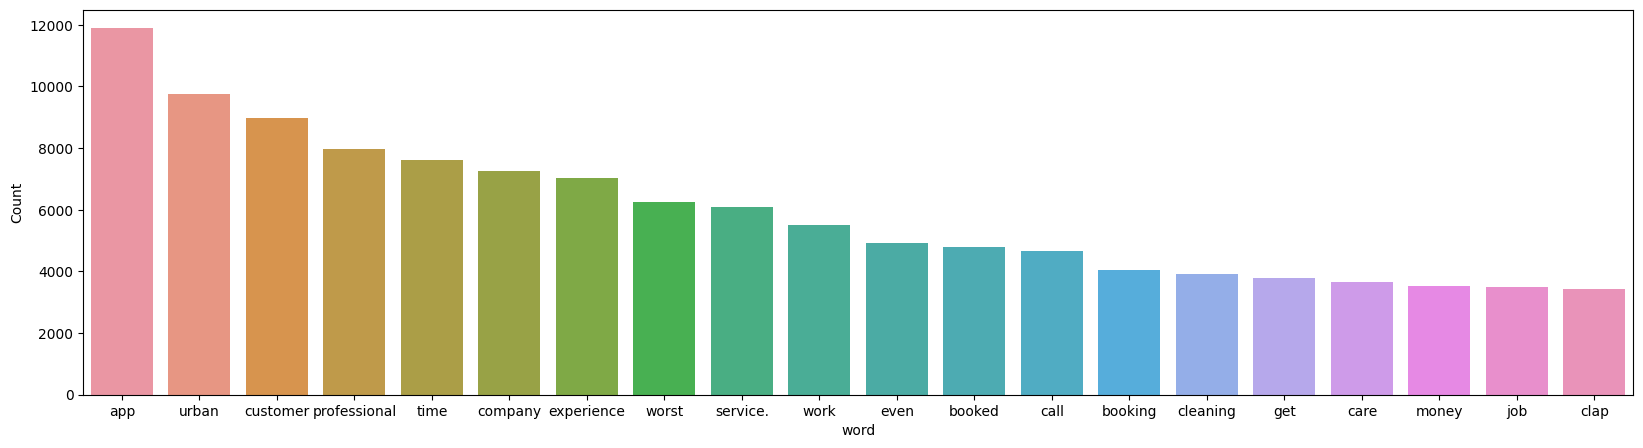

In [118]:
frequent_words(reviews_t,20)

In [119]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN','VERB']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [120]:
tokenized_reviews_t = pd.Series(reviews_t).apply(lambda x: x.split())
for word in tokenized_reviews_t:
    if(word in stop_list):
        tokenized_reviews_t.remove()  
print(tokenized_reviews_t[1000])

['maximum', 'professionals', 'mostly', 'salon', 'punctual.there', 'option', 'sehudule', 'time', '.that', 'useful', 'late', 'service.']


In [121]:
import gensim
bigram = gensim.models.Phrases(tokenized_reviews_t, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_reviews_t], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [122]:
start_time = time.time()
reviews_lt = lemmatization(tokenized_reviews_t)
print(reviews_lt[1])
end_time = time.time()
lematization_time = end_time - start_time
print(f"Lemmatization took {lematization_time:.4f} seconds.")

['find', 'phone', 'no', '.', 'call', 'option', 'use', 'option', 'talk', 'customer', 'care', 'use', 'guide', 'requirement', 'lack', 'book', 'service', 'look', 'app', 'find', 'connect', 'customer', 'care', 'app', 'design', 'issue', 'wonder', 'customer', 'talk', 'book']
Lemmatization took 296.4389 seconds.


In [123]:
import pandas as pd

# Assuming reviews_l is a list of lemmatized reviews
# Example: reviews_l = ["lemmatized review 1", "lemmatized review 2", ...]

# Create a DataFrame with 'content' column
preprocess_t = []
for i in reviews_lt:
    word_string = ' '.join(i) 
    preprocess_t.append(word_string)
dft = pd.DataFrame(preprocess_t, columns=['content'])

# Specify the file path for the CSV file
csv_file_path_t = 'lemmatized_reviews_t.csv'

# Save the DataFrame to a CSV file
dft.to_csv(csv_file_path_t, index=False)


In [124]:
print(dft.head())

                                                                                                                                                                            content
0                                              clarity tarrif get guy accept pay get tax invoice place ask revise invoice leave response explanation get invoice take do disappoint
1  find phone no . call option use option talk customer care use guide requirement lack book service look app find connect customer care app design issue wonder customer talk book
2                                                                  need trying cancel happen app start working partner come cancel force take service number take taxis explanation
3        application become day person show app give option pay option book service want money guarantee get time promise customer support make thing need alternative company lose
4                                                                                 use start find und

In [125]:
csv_file_path_t = 'lemmatized_reviews_t.csv'
# Read the CSV file into a new DataFrame
loaded_dft = pd.read_csv(csv_file_path_t)

# Print the head of the loaded DataFrame
print("Head of the Loaded DataFrame:")
print(loaded_dft.head())
loaded_dft.to_csv("preprocessedt.csv")

Head of the Loaded DataFrame:
                                                                                                                                                                            content
0                                              clarity tarrif get guy accept pay get tax invoice place ask revise invoice leave response explanation get invoice take do disappoint
1  find phone no . call option use option talk customer care use guide requirement lack book service look app find connect customer care app design issue wonder customer talk book
2                                                                  need trying cancel happen app start working partner come cancel force take service number take taxis explanation
3        application become day person show app give option pay option book service want money guarantee get time promise customer support make thing need alternative company lose
4                                                                     

In [126]:
s_time = time.time()
dict = Dictionary(reviews_lt)
print(reviews_lt[0])
document_term_matrixn = [dict.doc2bow(review) for review in reviews_lt]
new_latent_space = lda_model[document_term_matrixn]
e_time = time.time()
lda_time = e_time - s_time
print(f"LDA time took {lda_time:.4f} seconds.")

['clarity', 'tarrif', 'get', 'guy', 'accept', 'pay', 'get', 'tax', 'invoice', 'place', 'ask', 'revise', 'invoice', 'leave', 'response', 'explanation', 'get', 'invoice', 'take', 'do', 'disappoint']
LDA time took 3.1572 seconds.


In [141]:
topics = [
    [(word, float(prob)) for word, prob in re.findall(r'"([^"]*)"\s*\+\s*([0-9.]+)', topic_str)]
    for topic_id, topic_str in lda_model.print_topics()
]
print(topics)

[[('wax', 0.05), ('use', 0.045), ('get', 0.029), ('hair', 0.029), ('come', 0.027), ('product', 0.025), ('hand', 0.022), ('need', 0.019), ('skin', 0.017)], [('thank', 0.072), ('clap', 0.07), ('provide', 0.051), ('behaviour', 0.041), ('beautician', 0.027), ('thing', 0.026), ('lot', 0.026), ('clean', 0.019), ('underarm', 0.017)], [('service', 0.158), ('love', 0.04), ('call', 0.037), ('recommend', 0.029), ('lady', 0.028), ('like', 0.026), ('provide', 0.026), ('book', 0.02), ('look', 0.015)], [('experience', 0.193), ('time', 0.103), ('recommend', 0.037), ('clap', 0.026), ('say', 0.024), ('nature', 0.018), ('salon', 0.016), ('complete', 0.015), ('home', 0.014)], [('massage', 0.077), ('pedicure', 0.054), ('like', 0.052), ('book', 0.049), ('feel', 0.034), ('give', 0.033), ('relax', 0.028), ('wax', 0.027), ('pain', 0.024)], [('job', 0.191), ('do', 0.057), ('person', 0.029), ('know', 0.018), ('quality', 0.014), ('appointment', 0.013), ('talk', 0.013), ('way', 0.01), ('beauty', 0.009)], [('work',

In [201]:
print(new_latent_space[26])

[(0, 0.35857734), (2, 0.26045015), (3, 0.0503515), (4, 0.13608678), (5, 0.04907485), (6, 0.09118773), (7, 0.048854735)]


In [256]:
threshold = 0.5
classified_reviews = []
c = 0
for doc_topics in new_latent_space:
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    if sorted_topics[0][1] > threshold:
        classified_reviews.append("service")
    else:
        classified_reviews.append("platform") 

# 'classified_reviews' now contains the classifications for the new dataset
# print(classified_reviews)

In [257]:
from collections import Counter

# Count the occurrences of each element in the list using Counter
element_counts = Counter(classified_reviews)


# Iterate through the unique elements and print their count
for element, count in element_counts.items():
    print(f"Element: {element}, Count: {count}")


Element: platform, Count: 81738
Element: service, Count: 25324


In [258]:
for i in range(len(data1)):
        data1.at[i, 'lda_category'] = classified_reviews[i]

# Save the updated DataFrame back to a CSV file
data1.to_csv('lda_method.csv', index=False)



In [273]:
updated_dataset = pd.read_csv('lda_method.csv')

# Select only the 'content' and 'lda_category' columns
selected_columns = ['content', 'lda_category']
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
updated_dataset.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,lda_category
0,f2a7f983-75d9-4c3b-b306-4c4772b5ad5b,Aparna singh,https://play-lh.googleusercontent.com/a/AAcHTtc9Yqp0trV07irh_jXXpFKECppI8Qm7L1P3Wif3239c=mo,"There clarity for the services and there tarrifs. You opt for service you get quote from the service guy that you accept pay. When you get the tax invoice, different from the one you accepted first place. Then you ask for revised correct invoice, you are left with vague responses and explanations. can't even get the correct invoice the service taken from UC. Not done. Disappointed!!",1,103,7.5.9,04-08-2023 10:20,"Hi Aparna,\nApologies for the less-than-ideal experience. Please share detailed feedback of what went wrong, we assure you that we would help you with your concern. Please share the registered contact details along with your concern to resolve@urbancompany.com.\nRegards, Team Urban Company",04-08-2023 10:26,7.5.9,platform
1,d7f92130-0430-4eb0-8582-aac4c6770abc,Shiv G,https://play-lh.googleusercontent.com/a-/AD_cMMRfPUoVd3NI0DdmVq7opJaBMFatttcmIpoGuF1rB4IpbvQ,"just can't find your phone no. call back option. There used option talk customer care where someone used guide requirements. Due lack that not able book your services. looked everywhere the app but just can't find how connect customer care, It's annoying.. not sure it's app design issue intentionally they did it. intentional can only wonder why customer can't talk you how they will able book services !!!",1,673,7.4.99,01-06-2023 13:08,"Hi Shivesh,\nWe're really sorry that you’re experiencing problems. You can always reach out to us through the help center section on our app. However, please help us with your registered contact details and concerns at resolve@urbancompany.com and we will have a call arranged for you.\nRegards, Team Urban Company",01-06-2023 13:24,7.4.99,platform
2,f25b2b7b-eaf3-4a3f-9c2d-8aed464aca1d,Shatabhisha Ghosh,https://play-lh.googleusercontent.com/a-/AD_cMMTDlTsmh91_lujh1MtFtxpyRvxoLb5lR7RRWHAKjjtYmls,App does not open when you need open and does slow...horrible have been trying cancel booking but does not happen and the app starts working just when the partner about come and then you cannot cancel and forced take the service. Pathetic The more number service you take higher are the taxes without explanation,1,4,7.5.11,29-08-2023 03:25,"Hi Shatabhisha,\nWe apologize for the inconvenience caused. Kindly share your contact details with us at resolve@urbancompany.com. We will prioritize your concern and reach out to you via call to address the issue promptly.\nRegards, Team Urban Company",29-08-2023 03:38,7.5.11,platform
3,78dab723-dc59-4f21-8ffb-723d6b1fedb3,Madhurjya Baruah,https://play-lh.googleusercontent.com/a-/AD_cMMQLdgZpXTrE0d_aHFPPIX2nUzXgIVgr65Qm3B7e7vXwsAI,"The application becoming more and more unusable now days. Their service persons doesn't show up, the app not give the option for pay online after service option while booking any service. they want the money upfront, but without any guarantee that you will get the service time promised! Moreover, their non-existent customer support making the thing worse overall. need alternative now. Urban company has lost completely.",2,13,7.5.10,15-08-2023 14:49,"Hi Madhurjya,\nApologies for the less-than-ideal experience. We request you to please share your registered mobile number over resolve@urbancompany.com so that we can help you in a better way.\nRegards, Team Urban Company",15-08-2023 14:58,7.5.10,platform
4,af1a9654-77ae-4bb9-8977-37e13b5d408f,Navlyn Anna,https://play-lh.googleusercontent.com/a-/AD_cMMRY7ebsJVqEARxVU7uTeDdP2E3aFYqKiBtAOUbrce1Pers,Pretty good app but was hard use the starting. find difficult understand the app because things are bit complicated and have around asking people help me. Other than this think that the services provided are really good along with the people course. Love Urban Company. Keep

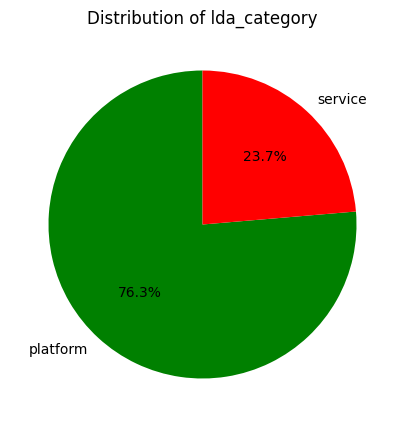

In [275]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset from the CSV file
original_dataset = pd.read_csv('lda_method.csv')

# Count the occurrences of each category
category_counts = original_dataset['lda_category'].value_counts()

# Plot a pie chart
plt.figure(figsize=(5,5))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of lda_category')
plt.show()


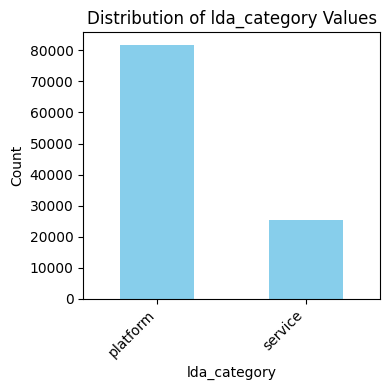

In [281]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your original dataset into 'original_dataset'

# Select only the 'content' and 'lda_category' columns
selected_columns = ['content', 'lda_category']
updated_dataset = original_dataset[selected_columns]

# Count the occurrences of each unique value in 'lda_category'
lda_category_counts = updated_dataset['lda_category'].value_counts()

# Plot the distribution using a bar chart
plt.figure(figsize=(4,4))
lda_category_counts.plot(kind='bar', color='skyblue')
plt.xlabel('lda_category')
plt.ylabel('Count')
plt.title('Distribution of lda_category Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
